# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:
- depth report
  - problema em alguns histogramas, mesmo capados (ex: 690)
  
- depth_info
  - mostrar o nome da variável 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from utils import (get_sorted_files,  
                   compute_scale_and_shift, 
                   cap_values,   
                   depth_report, 
                   calculate_delta,
                   abs_rel_error_mask)
import utils

# Affine-Invariant Alignment

## 1. Load data

In [38]:
diode_path = Path("/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/")
diode_indoor = diode_path / "val" / "indoors"
diode_outdoor = diode_path / "val" / "outdoor"
diode_preds = Path("/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/")

filenames_img = get_sorted_files(diode_path, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_preds, ".npy")

In [40]:
index = 585
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.squeeze(np.load(filenames_depth[index]))
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape
mask = np.load(filenames_mask[index]).reshape((H, W))

## 2. Pre Processing

In [41]:
mask_pred = np.ones_like(pred_diode)
mask_pred[pred_diode < 10] = 0

mask_full = mask * mask_pred

diode_depth_lim = 80
diode_disparity_lim = 1/diode_depth_lim

In [42]:
gt_depth_masked = np.zeros_like(groundtruth)
gt_depth_masked[mask_full == 1] = groundtruth[mask_full == 1]

gt_disp_masked = np.zeros_like(groundtruth)
gt_disp_masked[mask_full == 1] = 1.0 / groundtruth[mask_full == 1]
gt_disp_masked[gt_disp_masked < diode_disparity_lim] = diode_disparity_lim

pred_depth = np.zeros_like(groundtruth) 
pred_depth[mask_full == 1] = 1.0 / pred_diode[mask_full == 1]

gt_depth_capped = cap_values(groundtruth, 2, 98)
gt_disp_capped = cap_values(gt_disp_masked, 2, 98)

In [43]:
limit_mask = utils.percentile_mask(gt_disp_masked, 2, 98)
mask_full = mask_full * limit_mask

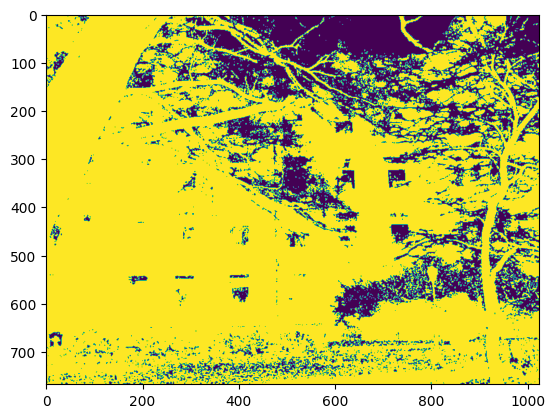

In [44]:
plt.imshow(mask_full)

Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

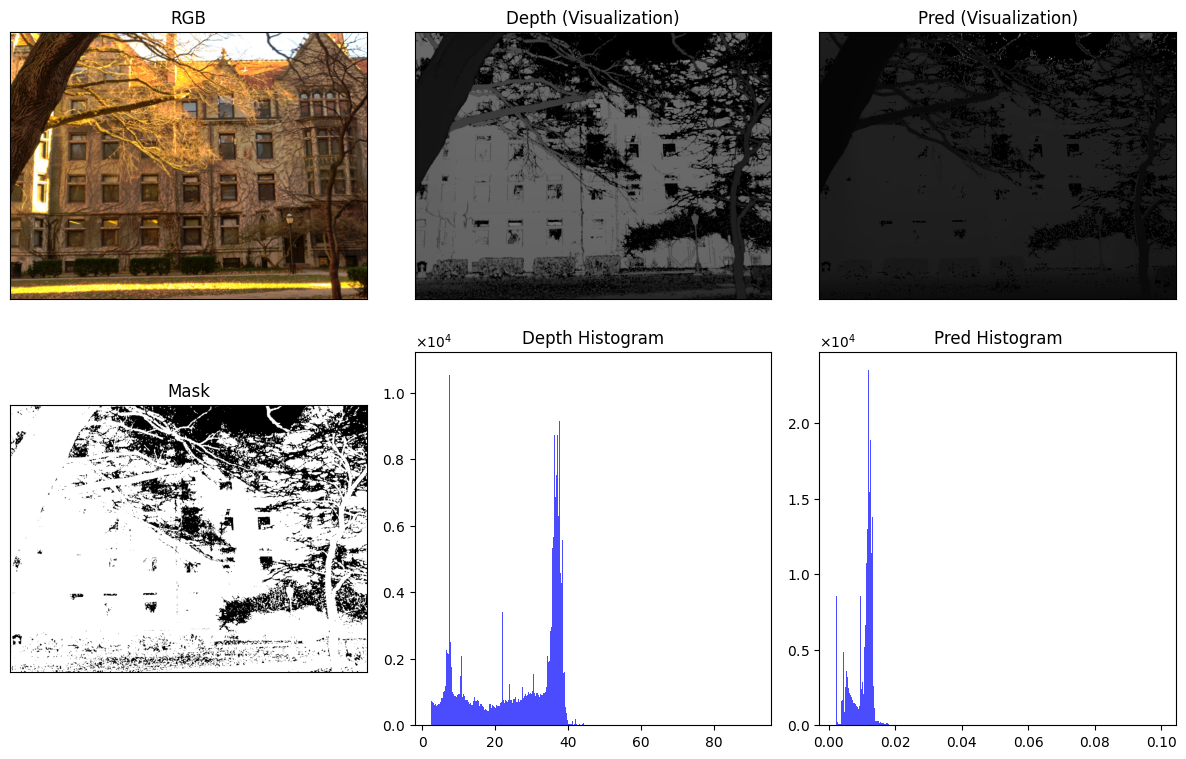

---- Depth Report ----

how many uniques: 570123
Max: 91.3553695678711
Min: 2.368108034133911
Dtype: float32
---- Depth Report ----

how many uniques: 578377
Max: 0.09967755526304245
Min: 0.0020865732803940773
Dtype: float32


In [45]:
depth_report(rgb, gt_depth_masked, pred_depth, mask=mask_full)

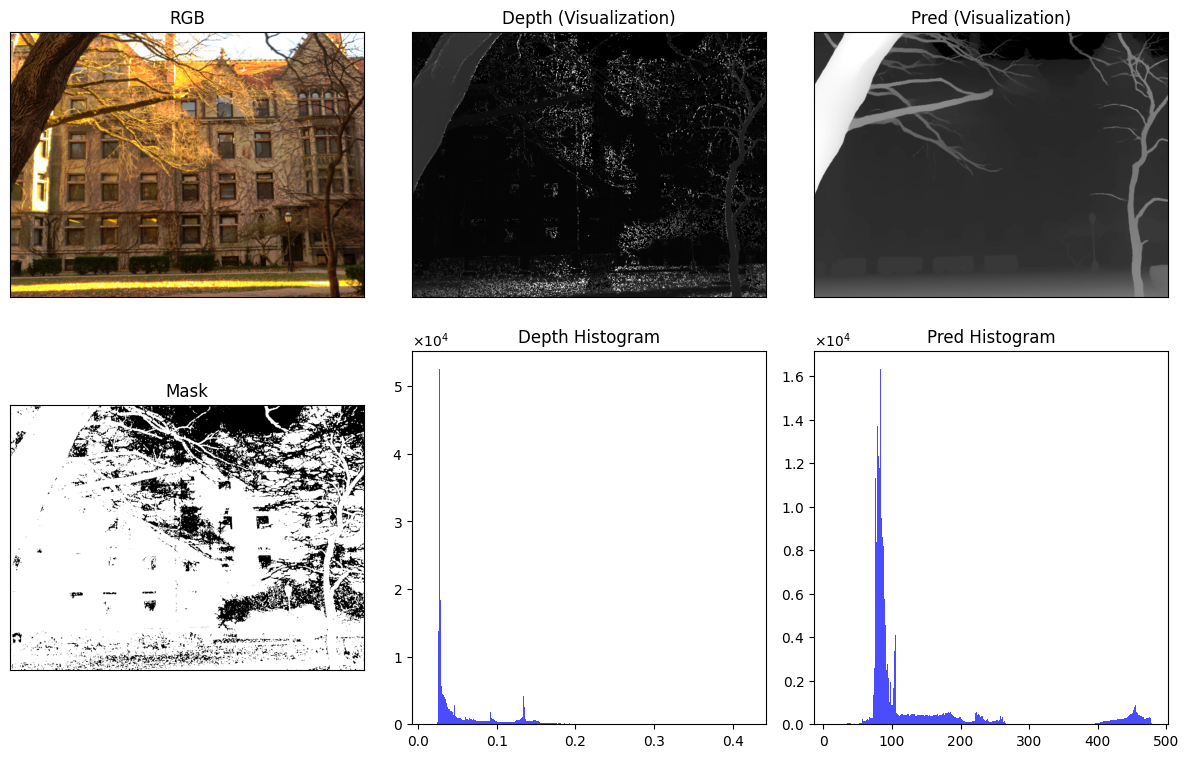

---- Depth Report ----

how many uniques: 568974
Max: 0.4222780466079712
Min: 0.012500000186264515
Dtype: float32
---- Depth Report ----

how many uniques: 579373
Max: 479.2546691894531
Min: 10.0323486328125
Dtype: float32


In [46]:
depth_report(rgb, gt_disp_masked, pred_diode,mask=mask_full, cap=True, uint=True)

### Test removing percentiles as mask

## 3. Alignment via least squares algorithm

In [72]:
gt_disp_normalized = utils.normalize_depth(gt_disp_masked)
pred_diode_normalized = utils.normalize_depth(pred_diode)

In [99]:
x_0, x_1 = compute_scale_and_shift(pred_depth, gt_depth_masked, mask_full)

In [100]:
prediction_aligned = x_0 * pred_depth + x_1
prediction_aligned = np.squeeze(prediction_aligned)*mask_full

depth_aligned_masked = np.zeros_like(pred_diode)
depth_aligned_masked[mask_full == 1] = prediction_aligned[mask_full == 1]
depth_aligned_capped = cap_values(depth_aligned_masked, 2, 98)

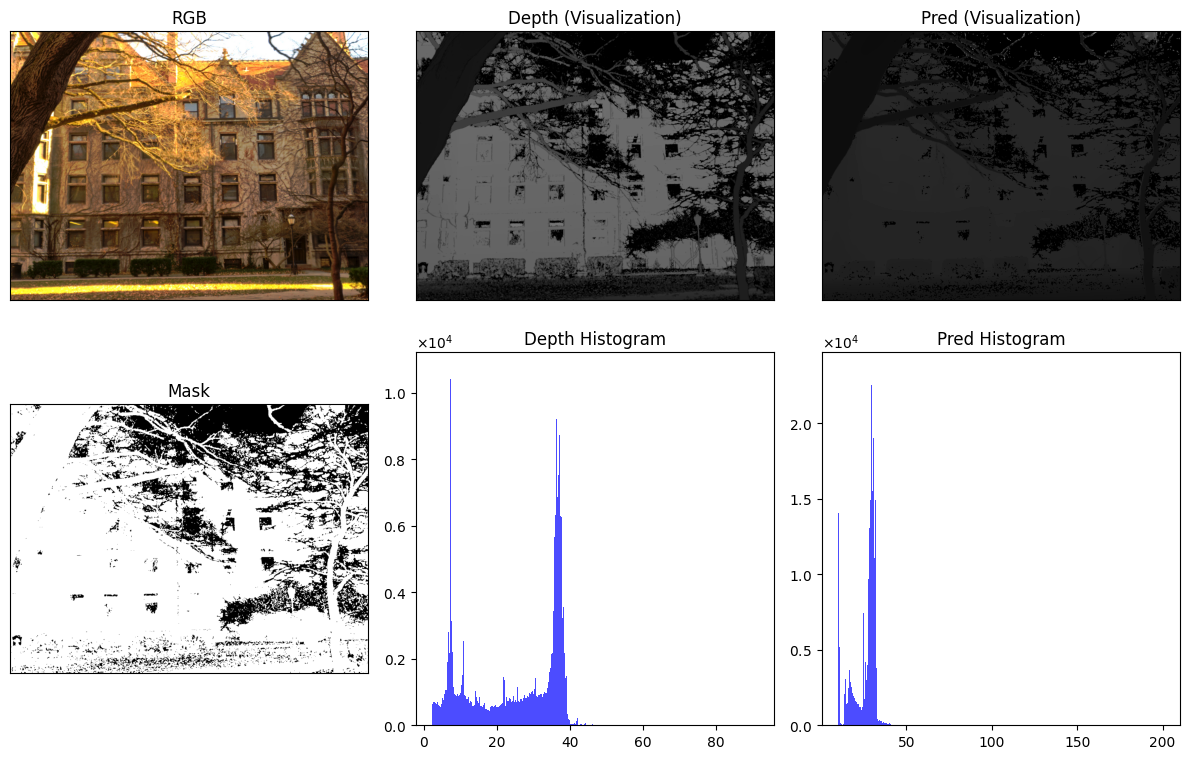

---- Depth Report ----

how many uniques: 570123
Max: 91.3553695678711
Min: 2.368108034133911
Dtype: float32
---- Depth Report ----

how many uniques: 573243
Max: 200.69503784179688
Min: 10.135396957397461
Dtype: float32


In [101]:
depth_report(rgb, gt_depth_masked, depth_aligned_masked, mask=mask_full, cap=False, uint=False)

----------------

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

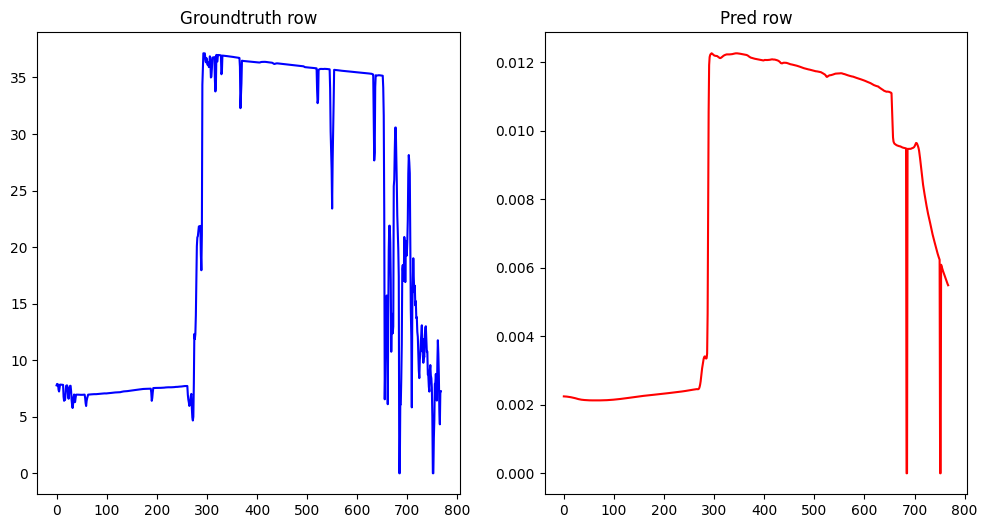

In [102]:
row_index = 100
GT_row = groundtruth[:, row_index]
pred_row = (pred_depth*mask_full)[:, row_index]
pred_aligned_row = depth_aligned_masked[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

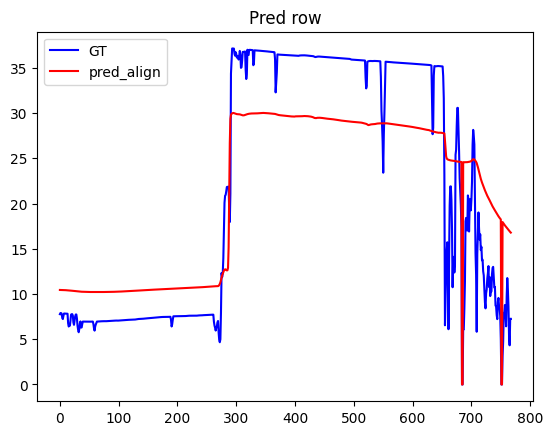

In [103]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

### 4.1 metrics on groundtruth masked

In [104]:
abs_rel_error_mask(depth_aligned_masked, gt_depth_masked, mask_full)

np.float32(0.46670088)

In [105]:
calculate_delta(depth_aligned_masked, groundtruth, mask_full, threshold=1.25)

np.float64(50.7728576684999)

### 4.2 metrics on groundtruth capped

In [90]:
abs_rel_error_mask(depth_aligned_capped, gt_depth_capped,mask_full)

np.float32(0.77801067)

In [91]:
calculate_delta(depth_aligned_capped, gt_depth_capped, mask_full, threshold=1.25)

np.float64(0.0)

## 5. Output the results